# Euclid AAS 247 Workshop -- 1a. Image Access

## Learning Goals

By the end of this tutorial, you will: 
- Understand the basic characteristics of Euclid Q1 MER mosaics.
- How to download a full MER mosaic from the cloud.
- How to download a cutout of a MER mosaic from the cloud.
- How to plot the MER cutout.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA. The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe. The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals. These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields: Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

Among the data products included in the Q1 release are the Level 2 MER mosaics. These are multiwavelength mosaics created from images taken with the Euclid instruments (VIS and NISP), as well as a variety of ground-based telescopes. All of the mosaics have been created according to a uniform tiling on the sky, and mapped to a common pixel scale. 

This notebook is an introduction to how to download from the cloud and understand the basic characteristics of the Euclid Q1 MER mosaics.

## Data volume

Each full MER image is approximately 1.47 GB. Downloading can take some time.

## Imports

In [ ]:
# Uncomment the next line to install dependencies if needed.
# !pip install s3fs numpy 'astropy>=5.3' matplotlib 'astroquery>=0.4.10' 'sep>=1.4' fsspec

In [1]:
import re

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch,  ZScaleInterval, SquaredStretch
from astropy.wcs import WCS
from astropy import units as u

from astroquery.ipac.irsa import Irsa
import sep

import pandas as pd
import json

import s3fs

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Introduction to Euclid Q1 MER mosaics

## 1a. Search for Euclid Q1 MER images based on object name

Search for Euclid Q1 MER images of a particular object, in this case a star 'HD 168151'.

Use IRSA to search for all Euclid data on this target. 
This searches specifically in the euclid_DpdMerBksMosaic "collection" which is the MER images and catalogs. 
This query will return any image with pixels that overlap the search region.

In [3]:
## Convert the star name to sky coordinates using an astropy function
coord_obj = SkyCoord.from_name('HD 168151')

## Define the search radius you want to search for images within.
search_radius_obj = 10 * u.arcsec

image_table_obj = Irsa.query_sia(pos=(coord_obj, search_radius_obj), collection='euclid_DpdMerBksMosaic')

In [4]:
## Convert the table to a pandas dataframe
df_obj=image_table_obj.to_pandas()

## Inspect the dataframe, just the science frames 
df_obj[(df_obj['dataproduct_subtype']=='science')]

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id,dist_to_point
0,273.740612,64.500014,CFHT,MegaCam,science,3,image,U,Optical,102158277_MegaCam,NaN,3.147510e-07,4.018390e-07,4.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_MegaCam/U,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188
1,273.740612,64.500014,Euclid,NISP,science,3,image,H,Infrared,102158277_NISP,0.1026,1.372000e-06,2.000000e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/H,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188
2,273.740612,64.500014,Subaru Telescope,Hyper Suprime-Cam,science,3,image,Z,Optical,102158277_WISHES,1.1500,8.363850e-07,9.490570e-07,7.9,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_WISHES/Z,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188
3,273.740612,64.500014,Euclid,NISP,science,3,image,Y,Infrared,102158277_NISP,0.0878,9.200000e-07,1.146000e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05

This dataframe contains lots of other datasets that have been "Euclidized", so put on the same pixel scale as the Euclid data. For this example choose science as the data product subtype to see all images of this tile.


In [5]:
print('There are',len(df_obj[(df_obj['dataproduct_subtype']=='science')]),'MER science images of this object/MER tile.')

There are 9 MER science images of this object/MER tile.


## 1b. Search for Euclid Q1 MER images based on coordinates

Search for Euclid Q1 MER images based on a particular RA and Dec, in this case the coordinates of the star 'HD 168151'.

In [6]:
## Define your RA and Dec
ra = 273.474451
dec = 64.397273

## Convert from RA and Dec to a "SkyCoord" object using an astropy function
coord_radec = SkyCoord(ra=ra, dec=dec, unit='deg')

## Define the search radius you want to search for images within.
search_radius_radec = 10 * u.arcsec

image_table_radec = Irsa.query_sia(pos=(coord_radec, search_radius_radec), collection='euclid_DpdMerBksMosaic')

In [7]:
## Convert the table to a pandas dataframe
df_radec=image_table_radec.to_pandas()

## Inspect the dataframe, just the science frames 
df_radec[(df_radec['dataproduct_subtype']=='science')]

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id,dist_to_point
0,273.740612,64.500014,CFHT,MegaCam,science,3,image,U,Optical,102158277_MegaCam,NaN,3.147510e-07,4.018390e-07,4.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_MegaCam/U,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188
1,273.740612,64.500014,Euclid,NISP,science,3,image,H,Infrared,102158277_NISP,0.1026,1.372000e-06,2.000000e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/H,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188
2,273.740612,64.500014,Subaru Telescope,Hyper Suprime-Cam,science,3,image,Z,Optical,102158277_WISHES,1.1500,8.363850e-07,9.490570e-07,7.9,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_WISHES/Z,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188
3,273.740612,64.500014,Euclid,NISP,science,3,image,Y,Infrared,102158277_NISP,0.0878,9.200000e-07,1.146000e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05

In [8]:
print('There are',len(df_radec[(df_radec['dataproduct_subtype']=='science')]),'MER science images of this object/MER tile.')

There are 9 MER science images of this object/MER tile.


## 2. Determine the location of the image file on the cloud

#### Find the URL of the images from the cloud.

The "cloud_access" column that gives the location info of the image file on the cloud. 

Note that 'access_estsize' is in units of kb

In [9]:
## Create a dataframe with only the Euclid Science images

df_sci=df_radec[((df_radec['dataproduct_subtype']=='science') & (df_radec['facility_name']=='Euclid'))].copy()

In [10]:
## Convert the "cloud_access" column into the location of the image file on the cloud

df_sci["cloud_dict"] = df_sci["cloud_access"].apply(json.loads)
df_sci["s3_path"] = df_sci["cloud_dict"].apply(
    lambda d: f"{d['aws']['bucket_name']}/{d['aws']['key']}"
)

In [11]:
df_sci

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id,dist_to_point,cloud_dict,s3_path
1,273.740612,64.500014,Euclid,NISP,science,3,image,H,Infrared,102158277_NISP,0.1026,1.372000e-06,2.000000e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/H,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188,"{'aws': {'bucket_name': 'nasa-irsa-euclid-q1', 'key': 'q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits', 'region': 'us-east-1'}}",nasa-irsa-euclid-q1/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits
3,273.740612,64.500014,Euclid,NISP,science,3,image,Y,Infrared,102158277_NISP,0.0878,9.200000e-07,1.146000e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/Y,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188,"{'aws': {'bucket_name': 'nasa-irsa-euclid-q1', 'key': 'q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits', 'region': 'us-east-1'}}",nasa-irsa-euclid-q1/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits
4,273.740612,64.500014,Euclid,VIS,science,3,image,VIS,Optical,102158277_VIS,0.1600,5.500000e-07,9.000000e-07,2.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_VIS/VIS,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits"", ""region"": "

## 3. Retreive a smaller cutout of the Euclid Q1 MER mosaic image of a region of interest

#### Due to the large file size, retrieve only a smaller cutout in a region of interest using fsspec and Cutout2D

In [12]:
######################## User defined section ############################
## How large do you want the image cutout to be?
im_cutout = 10 * u.arcsec

## What is the center of the cutout?
## For now choosing a random location on the image
ra = 273.8667
dec = 64.525

coords_cutout = SkyCoord(ra, dec, unit='deg', frame='icrs')
##########################################################################

In [13]:
df_sci

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id,dist_to_point,cloud_dict,s3_path
1,273.740612,64.500014,Euclid,NISP,science,3,image,H,Infrared,102158277_NISP,0.1026,1.372000e-06,2.000000e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/H,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188,"{'aws': {'bucket_name': 'nasa-irsa-euclid-q1', 'key': 'q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits', 'region': 'us-east-1'}}",nasa-irsa-euclid-q1/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits
3,273.740612,64.500014,Euclid,NISP,science,3,image,Y,Infrared,102158277_NISP,0.0878,9.200000e-07,1.146000e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/Y,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits"", ""region"": ""us-east-1""}}",,1,0.154188,"{'aws': {'bucket_name': 'nasa-irsa-euclid-q1', 'key': 'q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits', 'region': 'us-east-1'}}",nasa-irsa-euclid-q1/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits
4,273.740612,64.500014,Euclid,VIS,science,3,image,VIS,Optical,102158277_VIS,0.1600,5.500000e-07,9.000000e-07,2.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits,image/fits,1474566,NaN,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,NaN,,,,,field,NaN,False,,2025-05-01 00:00:00,19200,19200,0.1,False,NaN,NaN,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_VIS/VIS,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits"", ""region"": "

In [14]:
## Select the VIS-band row
row = df_sci[df_sci["energy_bandpassname"] == "VIS"].iloc[0]

## Extract the S3 path
s3_fpath = row["s3_path"]

## Open the FITS file from the cloud using fsspec
with fits.open(f's3://{s3_fpath}', fsspec_kwargs={"anon": True}) as hdul:
    print(f'Retrieving cutout for VIS-band')
    
    ## Store the original header
    header = hdul[0].header
    
    ## Read in the cutout of the image that you want
    cutout_data = Cutout2D(
        hdul[0].data,
        position=coords_cutout,
        size=im_cutout,
        wcs=WCS(header)
    )

## Define a new FITS file based on this smaller cutout,
## with accurate WCS based on the cutout size
new_hdu = fits.PrimaryHDU(data=cutout_data.data, header=header)
new_hdu.header.update(cutout_data.wcs.to_header())

Retrieving cutout for VIS-band


### Plot the cutout image with RA and Dec axes.

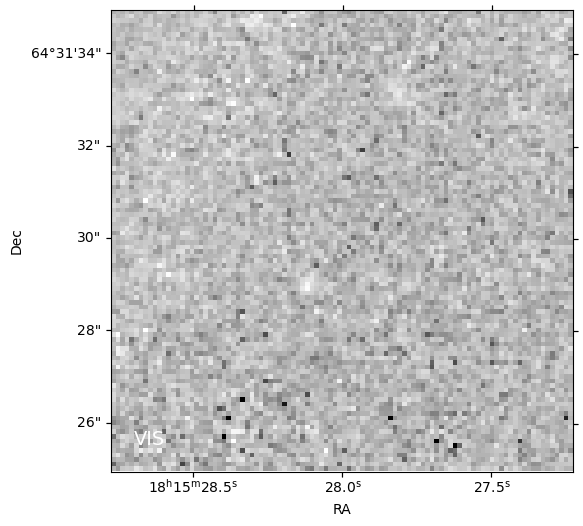

In [15]:
## Create a normalization for better contrast in the image
norm = ImageNormalize(new_hdu.data, interval=PercentileInterval(99.9), stretch=AsinhStretch())

## Use the WCS from the cutout
wcs = WCS(new_hdu.header)  

## Create figure and axes with WCS projection
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': wcs})

im = ax.imshow(new_hdu.data, cmap='gray', origin='lower', norm=norm)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.05, 0.05, 'VIS', color='white', fontsize=14,
        transform=ax.transAxes, va='bottom', ha='left')

plt.show()

## About this Notebook

**Author(s)**: Tiffany Meshkat <br>
**Keyword(s)**: Euclid, Q1, AAS 247 Workshop <br>
**First published**: Dec 11, 2025 <br>
**Last updated**: Dec 11, 2025